{/* cspell:ignore mactex, backgroundcolor, lightgreen */}

# Visualize circuit timing

<details>
<summary><b>Package versions</b></summary>

The code on this page was developed using the following requirements.
We recommend using these versions or newer.

```
qiskit[all]~=2.1.1
```
</details>

In addition to [visualizing instructions on a circuit](/docs/guides/visualize-circuits) you might want to use the Qiskit [`timeline_drawer`](/docs/api/qiskit/qiskit.visualization.timeline_drawer) method, which lets you visualize a circuit's scheduling. This visualization could help you to quickly spot idling time on qubits, for example.

<Admonition type="note" title="Notes">
- This is an experimental function. It is in preview release status and is therefore subject to change.
- This function only applies to Sampler jobs.
</Admonition>

## Examples

To visualize a scheduled circuit program, you can call this function with a set of control arguments. Most of the  output image's appearance can be modified by a stylesheet, but this is not required.

### Draw with the default stylesheet

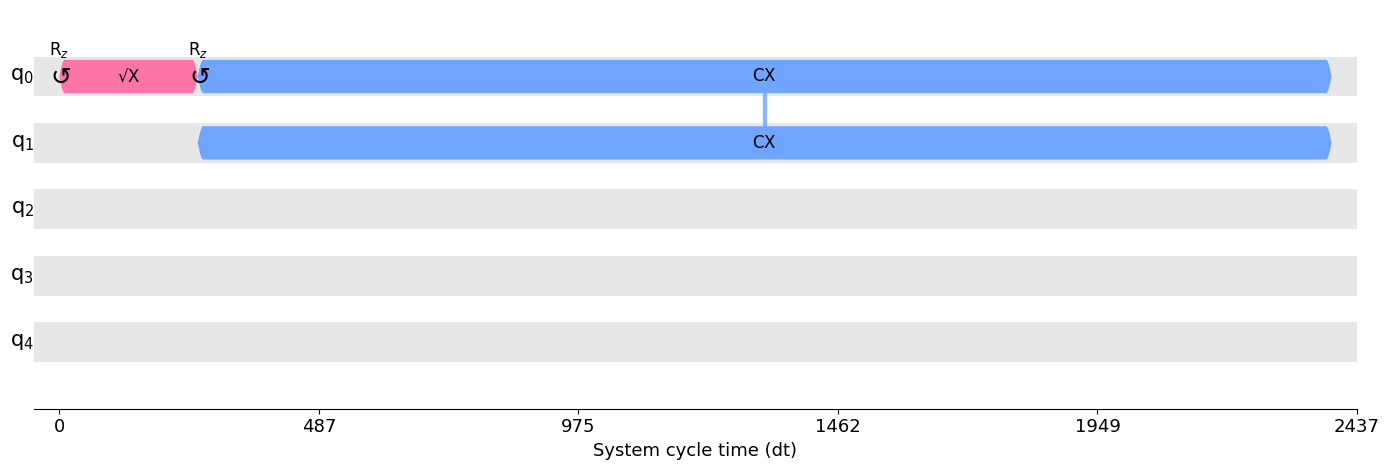

In [1]:
from qiskit import QuantumCircuit
from qiskit.visualization.timeline import draw
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import generate_preset_pass_manager

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

backend = GenericBackendV2(5)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

draw(isa_circuit, target=backend.target)

### Draw with a stylesheet suited for program debugging

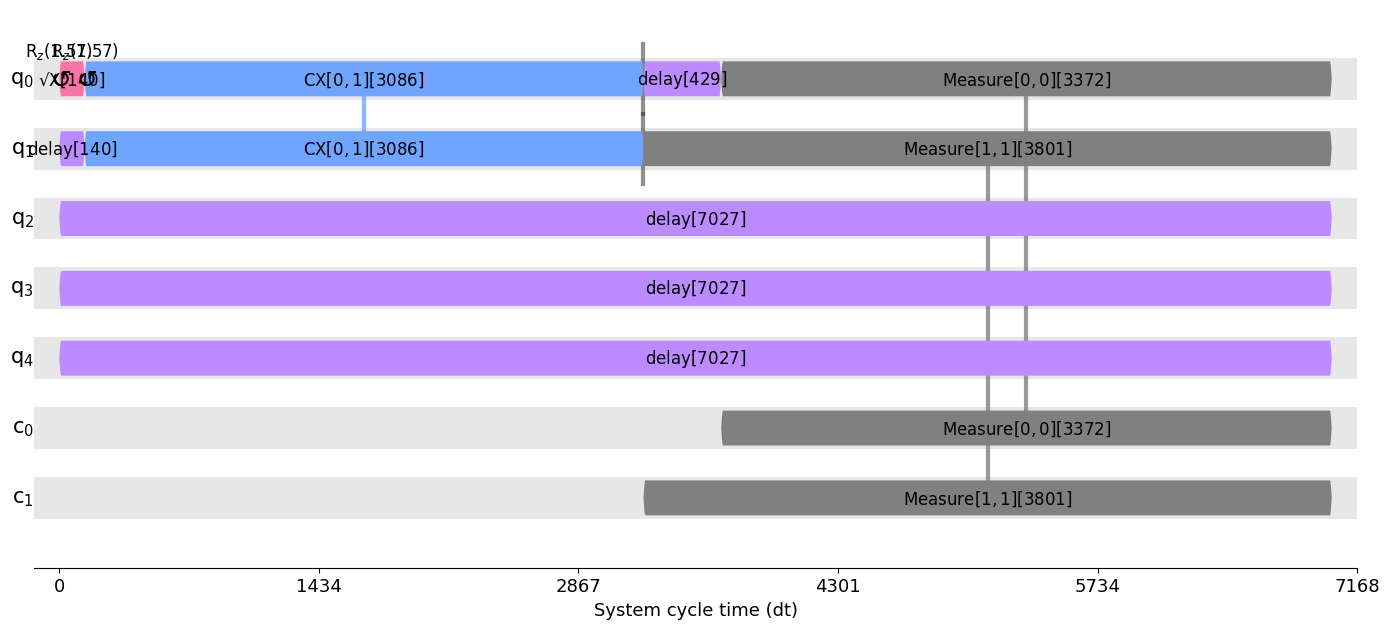

In [2]:
from qiskit import QuantumCircuit
from qiskit.visualization.timeline import draw, IQXDebugging
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import generate_preset_pass_manager

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

backend = GenericBackendV2(5)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
draw(isa_circuit, style=IQXDebugging(), target=backend.target)

You can create custom generator or layout functions and update an existing stylesheet with the custom functions. This way, you can control the most of the appearance of the output image without modifying the codebase of the scheduled circuit drawer.  See the [`timeline_drawer`](/docs/api/qiskit/qiskit.visualization.timeline_drawer) API reference for more examples.

## Qiskit Runtime support

While the timeline drawer built in to Qiskit is useful for static circuits, it might not accurately reflect the timing of [dynamic circuits](/docs/guides/classical-feedforward-and-control-flow) because of implicit operations such as broadcasting and branch determination. As part of dynamic circuit support, Qiskit Runtime returns the accurate circuit timing information inside the job results when requested.

### Enable timing data retrieval

To enable timing data retrieval, set the experimental `scheduler_timing` flag to `True` when running the primitive job.

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

sampler = SamplerV2(backend)
sampler.options.experimental = {
    "execution": {
        "scheduler_timing": True,
    },
}

sampler_job = sampler.run([isa_circuit])

management.get:WARNING:2025-10-09 14:47:33,541: Loading default saved account


IBMInputValueError: 'The given API token is associated with an account that does not have access to the instance crn:v1:bluemix:public:quantum-computing:us-east:a/6c63dae5281147f1a0449b36e0aaba3a:cbf14cbc-4b63-4698-868e-8bb92dbcc8f4::. To use this instance, use an API token generated from the account with this instance available.'

### Access the circuit timing data

When requested, the circuit timing data is returned in the job result metadata, under `["compilation"]["scheduler_timing"]["timing"]`. This field contains the raw timing information. To display the timing information, use the built-in visualization tool to display it, as described in the following section.

Use the following code to access the circuit timing data:

In [ ]:
job_result = sampler_job.result()
circuit_schedule = job_result[0].metadata["compilation"]["scheduler_timing"]
circuit_schedule_timing = circuit_schedule["timing"]

### Visualize the timings

To visualize the timings, you first need to convert the result metadata to `fig` by using the `draw_circuit_schedule_timing` (**link to API reference when available**) method. This method returns a `plotly` figure, which you can display directly, save to a file, or both.

In [ ]:
from qiskit_ibm_runtime.visualization import draw_circuit_schedule_timing

# Create a figure from the metadata
fig = draw_circuit_schedule_timing(
    circuit_schedule=circuit_schedule_timing,
    included_channels=None,
    filter_readout_channels=False,
    filter_barriers=False,
    width=1000,
)

# Display the figure
fig.show(renderer="notebook")

# Save to a file
fig.write_html("scheduler_timing.html")

For more information about the `plotly` commands, see [`fig.show()`](https://plotly.com/python-api-reference/generated/plotly.io.show.html) and  [`fig.write_image("<path.format>")`.](https://plotly.com/python-api-reference/generated/plotly.io.write_image.html)

### Understand the raw timing data

While visualizing the circuit timing data by using the `draw_circuit_schedule_timing` method is the most common use case, it might be useful to understand the structure of the raw timing data returned. This could help you, for example, to extract information programmatically.

The timing data returned in `["compilation"]["scheduler_timing"]["timing"]` is a list of strings. Each string represents a single instruction on some channel and is comma separated into the following data types:

- `Branch` - Determines whether the instruction is in a control flow (then / else) or a main branch
- `Instruction` - The gate and the qubit to operate on
- `Channel` - The channel that is being assigned with the instruction (Qubit x / AWGRx_y / ...). Arbitrary Wave Generator Readout (AWGR) is used for readout channels communication for measuring qubits, as opposed to drive channels, which are for driving the qubits. The `X` and `Y` arguments correspond to the readout instrument ID and the qubit number, respectively.
- `T0` - The instruction start time within the complete schedule
- `Duration` - The instruction's duration
- `Pulse` - The type of pulse operation being used


Example:

```python
main,barrier,Qubit 0,7,0,barrier # A barrier on the main branch on qubit 0 at time 7 with 0 duration
main,reset_0,Qubit 0,7,64,play # A reset instruction on the main branch on qubit 0 at time 7 with duration 64 and a play operation
...
```

### Understand the generated figure

The image of the circuit timing data output by `draw_circuit_schedule_timing` conveys the following information:

- X axis is time in units of _dt_ seconds,  where 1 dt = 1 scheduling cycle.
- Y axis is the channel (think of channels as instruments that emit pulses).
    - `Receive channel` is the only channel that isn't an instrument by itself. It is an instruction played on all channels that are part of a communication procedure with the hub at that time.
    - `Qubit x` is the drive channel for qubit x.
    - `AWGRx_y` (arbitrary wave generator readout) is used for readout channels communication for measuring qubits. The x and y arguments correspond to the readout instrument ID and the qubit number, respectively.
    - `Hub` controls broadcasting.

Additionally, each instruction has the format of *X_Y*, where *X* is the name of the instruction and *Y* is the pulse type. A `play` type applies control pulses, and a `capture` records the qubit's state.

### End-to-end example

This example shows you how to enable the option, get it from the metadata, display it, and save it to a file.

First, set up the environment, define the circuits and convert them to ISA circuits, and define and run the jobs.

In [ ]:
from qiskit_ibm_runtime import SamplerV2
from qiskit.circuit import QuantumCircuit

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

# Create a Bell circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

qc.draw()

# Convert to an ISA circuit for the given backend

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

# Generate samplers for backend targets
sampler = SamplerV2(backend)
sampler.options.experimental = {
    "execution": {"scheduler_timing": True},
}

# Submit jobs
sampler_job = sampler.run(isa_circuit)

print(
    f">>> {' Job ID:':<10}  {sampler_job.job_id()} ({sampler_job.status()})"
)

result = sampler_job.result()
print(f">>> {' Job:':<10} {sampler_job.job_id()} finished with:\n{result}")

Next, get the circuit schedule timing:

In [ ]:
# Get the circuit schedule timing
result[0].metadata["compilation"]["scheduler_timing"]["timing"]

Finally, you can visualize and save the timing:

In [ ]:
from qiskit_ibm_runtime.visualization import draw_circuit_schedule_timing

circuit_schedule = (
    result[0]
    .metadata["compilation"]["scheduler_timing"]["timing"]
    .split("\n")
)
fig = draw_circuit_schedule_timing(
    circuit_schedule=circuit_schedule,
    included_channels=None,
    filter_readout_channels=False,
    filter_barriers=False,
    width=1000,
)

# Display the figure
fig.show(renderer="notebook")

## Next steps

<Admonition type="tip" title="Recommendations">
  - [Classical feedforward and control flow](/docs/guides/classical-feedforward-and-control-flow) (dynamic circuits)
  - [Visucalize circuits](/docs/guides/Visualize circuits)
</Admonition>